In [24]:
import os
import gc
import time
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score, confusion_matrix

import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

In [28]:
pd.set_option('display.max_columns', 200)
DATA_PATH = '/mnt/data/Fraud.csv'
OUTPUT_DIR = './output'
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

In [34]:
SAMPLE_MODE = True # Set to True to train faster on a balanced sample for prototyping
SAMPLE_SIZE_NEG = 200000 # number of negative (non-fraud) samples to keep when sampling
SAMPLE_SIZE_POS = None # keep all positives by default
RANDOM_STATE = 42
# %%
# 2) Load data and quick EDA
print('Loading data from', DATA_PATH)
df = pd.read_csv("Fraud.csv") 
print('Shape:', df.shape)
print('\nColumns and dtypes:')
print(df.dtypes)
print('\nHead:')
print(df.head())

Loading data from /mnt/data/Fraud.csv
Shape: (6362620, 11)

Columns and dtypes:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Head:
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225

In [40]:
# Check missing values
print('\nMissing values per column:')
print(df.isna().sum())

# Basic target distribution
fraud_counts = df['isFraud'].value_counts()
print('\nFraud distribution:')
print(fraud_counts)
print('Fraud rate: {:.6f}'.format(df['isFraud'].mean()))

# Quick stats on amount
print('\nAmount summary:')
print(df['amount'].describe())


Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Fraud distribution:
isFraud
0    6354407
1       8213
Name: count, dtype: int64
Fraud rate: 0.001291

Amount summary:
count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64


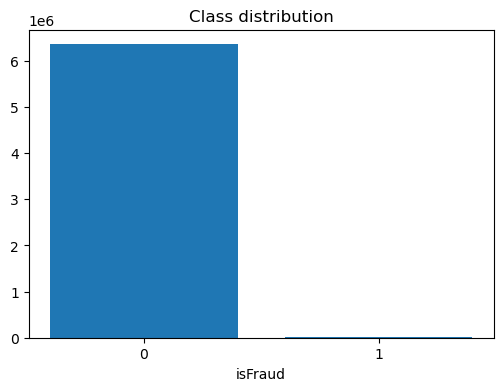

In [42]:
# %%
# Plot class imbalance (small plot)
plt.figure(figsize=(6,4))
plt.bar([0,1], [fraud_counts.get(0,0), fraud_counts.get(1,0)])
plt.xticks([0,1])
plt.xlabel('isFraud')
plt.title('Class distribution')
plt.show()

In [52]:
# %%
# 3) Basic Cleaning and Feature Engineering functions

# Copy to avoid modifying in place
def basic_feature_engineering(df):
    df = df.copy()
    

# types
    df['type'] = df['type'].astype('category')


# Merchant flag for destination (nameDest starting with 'M')
    df['is_dest_merchant'] = df['nameDest'].str.startswith('M').astype(int)


# Balance deltas (note sign conventions)
# delta_org = old - new (positive if money left origin)
    df['delta_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
# delta_dest = new - old (positive if money added to dest)
    df['delta_dest'] = df['newbalanceDest'] - df['oldbalanceDest']


# Validate relationship: delta_orig vs amount (should match closely for many transaction types)
    df['amount_log1p'] = np.log1p(df['amount'])


# Rapid emptying indicator
    df['rapid_empty'] = (df['newbalanceOrig'] == 0).astype(int)


# Large transfer flag (business rule > 200000)
    df['large_transfer_flag'] = (df['amount'] > 200000).astype(int)


# Time features
    df['hour_of_day'] = df['step'] % 24
    df['day'] = df['step'] // 24


# Basic interaction features
    df['type_amount'] = df['amount_log1p'] # we will let LightGBM handle categorical 'type' interactions


    return df


In [54]:
df = basic_feature_engineering(df)
print('After basic FE shape:', df.shape)
print(df[['amount','amount_log1p','delta_orig','delta_dest','rapid_empty','is_dest_merchant']].head())

After basic FE shape: (6362620, 20)
     amount  amount_log1p  delta_orig  delta_dest  rapid_empty  \
0   9839.64      9.194276     9839.64         0.0            0   
1   1864.28      7.531166     1864.28         0.0            0   
2    181.00      5.204007      181.00         0.0            1   
3    181.00      5.204007      181.00    -21182.0            1   
4  11668.14      9.364703    11668.14         0.0            0   

   is_dest_merchant  
0                 1  
1                 1  
2                 0  
3                 0  
4                 1  


In [58]:
# %%
# 4) Create light-weight behavioral features (efficiently)
# NOTE: For full production you should compute time-aware rolling windows per user in streaming or with grouped windows.
# Here we compute a few cumulative counts/means which are causal if we ensure step ordering per user.

# Sort by nameOrig & step to compute cumulative counts per origin
print('Computing cumulative aggregates per origin (lightweight)')
df = df.sort_values(['nameOrig', 'step']).reset_index(drop=True)
# cumulative count of transactions for origin up until (but excluding) this transaction
# We'll use groupby.cumcount which counts previous transactions of the same origin

df['orig_cumcount'] = df.groupby('nameOrig').cumcount()
# moving average of amount per origin (cumulative mean)
df['orig_cumamount_mean'] = df.groupby('nameOrig')['amount'].transform('cumsum') / (df['orig_cumcount'] + 1)

# For destination similar features
print('Computing cumulative aggregates per destination')
df = df.sort_values(['nameDest', 'step']).reset_index(drop=True)
df['dest_cumcount'] = df.groupby('nameDest').cumcount()
df['dest_cumamount_mean'] = df.groupby('nameDest')['amount'].transform('cumsum') / (df['dest_cumcount'] + 1)

# Re-sort back by step for time-based split later
df = df.sort_values('step').reset_index(drop=True)

print('Sample engineered features:')
print(df[['nameOrig','step','orig_cumcount','orig_cumamount_mean','nameDest','dest_cumcount','dest_cumamount_mean']].head(10))

Computing cumulative aggregates per origin (lightweight)
Computing cumulative aggregates per destination
Sample engineered features:
      nameOrig  step  orig_cumcount  orig_cumamount_mean     nameDest  \
0  C1278839936     1              0            257348.03   C985934102   
1   C944752500     1              0              7512.61   M238874235   
2   C948960194     1              0               663.34   M173060252   
3   C100708535     1              0            377287.80   C985934102   
4   C519303080     1              0              4252.82  M1345265484   
5   C976358110     1              0              9800.58  M1690233783   
6   C695248316     1              0           1201716.66   C665576141   
7   C663215704     1              0             69865.39   C665576141   
8   C556945462     1              0            280403.82   C665576141   
9   C555943503     1              0            957339.52   C665576141   

   dest_cumcount  dest_cumamount_mean  
0              3       

In [62]:
# %%
# 5) Train/validation split (time-based)
# We split by step: use earlier steps for training and later steps for validation to simulate production.
max_step = df['step'].max()
train_cut_step = int(max_step * 0.8) # 80% earliest steps for training
print('Max step:', max_step, 'Train cut step:', train_cut_step)

train_df = df[df['step'] <= train_cut_step].copy()
val_df = df[df['step'] > train_cut_step].copy()
print('Train shape:', train_df.shape, 'Val shape:', val_df.shape)
print('Train fraud rate:', train_df['isFraud'].mean(), 'Val fraud rate:', val_df['isFraud'].mean())


Max step: 743 Train cut step: 594
Train shape: (6239040, 24) Val shape: (123580, 24)
Train fraud rate: 0.0010512835307996103 Val fraud rate: 0.01338404272536009


In [66]:
# %%
# 6) Optional sampling for prototyping (handles class imbalance and reduces runtime)
if SAMPLE_MODE:
    print('Sampling mode ON: creating a smaller training set for prototyping')
    pos = train_df[train_df['isFraud'] == 1]
    neg = train_df[train_df['isFraud'] == 0]
    print('Original train pos/neg:', len(pos), len(neg))
    if SAMPLE_SIZE_POS is None:
        sampled_pos = pos
    else:
        sampled_pos = pos.sample(n=SAMPLE_SIZE_POS, random_state=RANDOM_STATE)
    sampled_neg = neg.sample(n=min(SAMPLE_SIZE_NEG, len(neg)), random_state=RANDOM_STATE)
    train_sample = pd.concat([sampled_pos, sampled_neg]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    print('Sampled train shape:', train_sample.shape, 'Pos:', train_sample['isFraud'].sum())
else:
    train_sample = train_df


# For validation, use full val_df (do not sample validation)
val_sample = val_df

Sampling mode ON: creating a smaller training set for prototyping
Original train pos/neg: 6559 6232481
Sampled train shape: (206559, 24) Pos: 6559


In [72]:
# %%
# 7) Features selection and data preparation for training
# We'll define a set of features to use. Avoid using raw IDs (nameOrig, nameDest) directly.


features = [
'type', 'amount', 'amount_log1p', 'is_dest_merchant', 'oldbalanceOrg', 'newbalanceOrig',
'oldbalanceDest', 'newbalanceDest', 'delta_orig', 'delta_dest', 'rapid_empty', 'large_transfer_flag',
'hour_of_day', 'day', 'orig_cumcount', 'orig_cumamount_mean', 'dest_cumcount', 'dest_cumamount_mean'
]


# Ensure features exist
features = [f for f in features if f in train_sample.columns]
print('Using features:', features)


# Prepare datasets
X_train = train_sample[features].copy()  # Added .copy() to create a true copy
y_train = train_sample['isFraud']
X_val = val_sample[features].copy()      # Added .copy() to create a true copy
y_val = val_sample['isFraud']


# LightGBM categorical features
categorical_features = ['type']


# For tree-based models, missing numeric values are OK. Convert categorical to category dtype
for c in categorical_features:
    X_train.loc[:, c] = X_train[c].astype('category')  # Using .loc to avoid the warning
    X_val.loc[:, c] = X_val[c].astype('category')      # Using .loc to avoid the warning

Using features: ['type', 'amount', 'amount_log1p', 'is_dest_merchant', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'delta_orig', 'delta_dest', 'rapid_empty', 'large_transfer_flag', 'hour_of_day', 'day', 'orig_cumcount', 'orig_cumamount_mean', 'dest_cumcount', 'dest_cumamount_mean']


In [76]:
# %%
# 8) LightGBM training

import time  # Added import for time module
import os    # Added import for os module
import lightgbm as lgb  # Added import for lightgbm

ess_start = time.time()

params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'verbosity': -1,
}

# Handle class imbalance via scale_pos_weight = negatives / positives
neg_count = (y_train==0).sum()
pos_count = (y_train==1).sum()
params['scale_pos_weight'] = (neg_count / max(1, pos_count))
print('Train neg/pos:', neg_count, pos_count, 'scale_pos_weight:', params['scale_pos_weight'])

dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
dval = lgb.Dataset(X_val, label=y_val, reference=dtrain, categorical_feature=categorical_features, free_raw_data=False)

# Corrected: Using callbacks for early stopping instead of early_stopping_rounds parameter
model = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dval],
    valid_names=['train','valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=50)]  # Corrected parameter
)

print('Training completed in {:.1f}s'.format(time.time() - ess_start))

# Save model
model.save_model(os.path.join(OUTPUT_DIR, 'lgb_model.txt'))
print('Saved LightGBM model to', os.path.join(OUTPUT_DIR, 'lgb_model.txt'))

Train neg/pos: 200000 6559 scale_pos_weight: 30.49245311785333
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.999929	valid's auc: 0.99988
[100]	train's auc: 0.999974	valid's auc: 0.999907
[150]	train's auc: 0.99999	valid's auc: 0.9999
Early stopping, best iteration is:
[135]	train's auc: 0.999986	valid's auc: 0.999912
Training completed in 2.4s
Saved LightGBM model to ./output\lgb_model.txt


In [78]:
# %%
# 9) Evaluation on validation set


y_pred_prob = model.predict(X_val, num_iteration=model.best_iteration)


roc_auc = roc_auc_score(y_val, y_pred_prob)
pr_auc = average_precision_score(y_val, y_pred_prob)


print('\nValidation ROC-AUC: {:.6f}'.format(roc_auc))
print('Validation PR-AUC: {:.6f}'.format(pr_auc))


# Precision/Recall at chosen threshold (we'll tune threshold using f1 or business metric)
threshold = 0.5
y_pred_label = (y_pred_prob >= threshold).astype(int)
precision = precision_score(y_val, y_pred_label)
recall = recall_score(y_val, y_pred_label)
f1 = f1_score(y_val, y_pred_label)


print('\nAt threshold {:.2f} -> Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}'.format(threshold, precision, recall, f1))


# Confusion matrix
cm = confusion_matrix(y_val, y_pred_label)
print('\nConfusion matrix (rows: true, cols: pred):\n', cm)


Validation ROC-AUC: 0.999912
Validation PR-AUC: 0.993618

At threshold 0.50 -> Precision: 0.6242, Recall: 1.0000, F1: 0.7686

Confusion matrix (rows: true, cols: pred):
 [[120930    996]
 [     0   1654]]


Precision@100 = 1.0000
Precision@500 = 1.0000
Precision@1000 = 1.0000
Precision@5000 = 0.3308


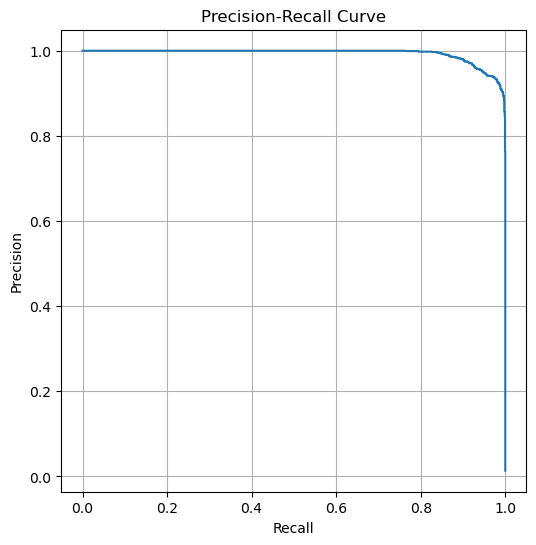

In [84]:
# %%
# 10) Precision@K and top-percentile analysis


def precision_at_k(y_true, y_score, k):
    # return precision among top k scored samples
    idx = np.argsort(y_score)[-k:]
    return y_true.iloc[idx].mean()


# Compute Precision@k for several k values (e.g., top 100, 500, 1000)
ks = [100, 500, 1000, 5000]
for k in ks:
    if k < len(y_val):  # This line was not properly indented
        p_at_k = precision_at_k(y_val.reset_index(drop=True), y_pred_prob, k)
        print('Precision@{} = {:.4f}'.format(k, p_at_k))


# Precision-Recall curve
precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_val, y_pred_prob)


plt.figure(figsize=(6,6))
plt.plot(recall_vals, precision_vals)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [86]:
# %%
# 11) Monetary impact estimate (rough)
# Assume fraud amount is the 'amount' of fraudulent transactions; compute total fraud amount in validation
val_df_with_preds = val_sample.copy()
val_df_with_preds['pred_score'] = y_pred_prob
val_df_with_preds['pred_label_0_5'] = y_pred_label


# Total fraud monetary loss (true positives + false negatives)
true_fraud_amount = val_df_with_preds.loc[val_df_with_preds['isFraud']==1, 'amount'].sum()
print('\nTotal fraud amount in validation period: {:.2f}'.format(true_fraud_amount))


# If we block predictions where pred_label==1, money prevented (TP amount)
tp_amount = val_df_with_preds.loc[(val_df_with_preds['isFraud']==1) & (val_df_with_preds['pred_label_0_5']==1), 'amount'].sum()
fp_amount = val_df_with_preds.loc[(val_df_with_preds['isFraud']==0) & (val_df_with_preds['pred_label_0_5']==1), 'amount'].sum()


print('Amount prevented (TP): {:.2f}, Amount blocked (FP): {:.2f}'.format(tp_amount, fp_amount))


Total fraud amount in validation period: 2722434569.36
Amount prevented (TP): 2722434569.36, Amount blocked (FP): 115260200.51


Computing SHAP explanations (may take time; sampling used)


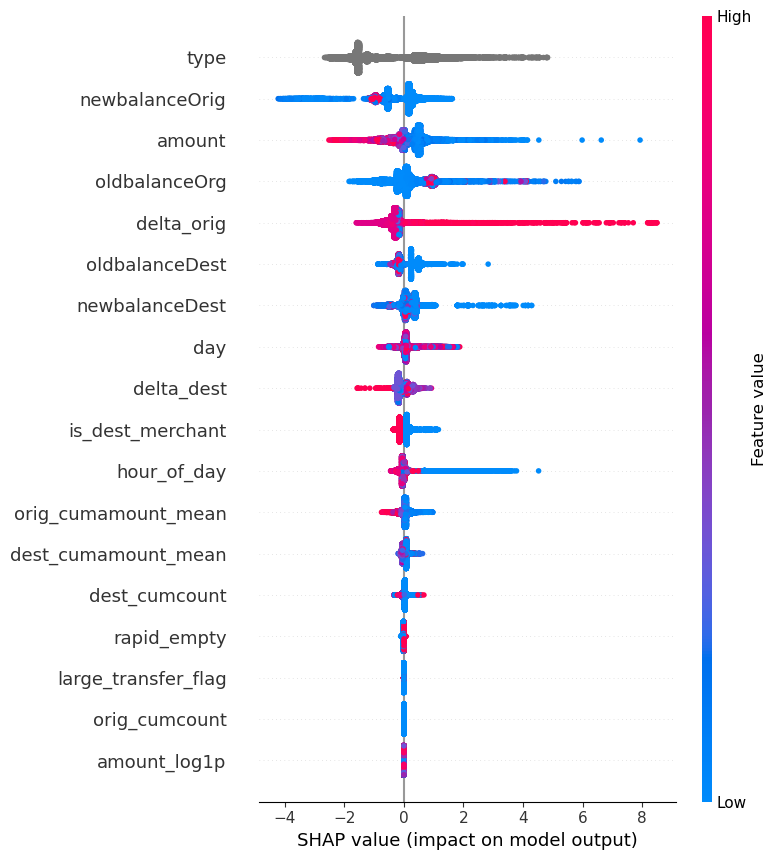

In [98]:
# %%
# 12) Explainability: SHAP (if available)
if shap is not None:
    print('Computing SHAP explanations (may take time; sampling used)')
    # sample for SHAP
    n_shap_sample = 20000
    shap_sample = val_sample.sample(n=min(n_shap_sample, len(val_sample)), random_state=RANDOM_STATE)
    shap_X = shap_sample[features]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(shap_X)

    # Summary plot
    try:
        shap.summary_plot(shap_values, shap_X, show=True)
    except Exception as e:
        print('SHAP plotting error:', e)
        # fallback: compute mean absolute SHAP per feature
        import numpy as _np
        mean_abs_shap = _np.abs(shap_values).mean(axis=0)
        imp_df = pd.DataFrame({'feature': shap_X.columns, 'mean_abs_shap': mean_abs_shap}).sort_values('mean_abs_shap', ascending=False)
        print(imp_df)
        imp_df.to_csv(os.path.join(OUTPUT_DIR, 'shap_feature_importance.csv'), index=False)
        print('Wrote shap importance to', os.path.join(OUTPUT_DIR, 'shap_feature_importance.csv'))
else:
    print('shap not installed; generating LightGBM feature importance instead')
    fi = pd.DataFrame({'feature': model.feature_name(), 'importance': model.feature_importance()}).sort_values('importance', ascending=False)
    print(fi)
    fi.to_csv(os.path.join(OUTPUT_DIR, 'lgb_feature_importance.csv'), index=False)
    print('Wrote feature importance to', os.path.join(OUTPUT_DIR, 'lgb_feature_importance.csv'))

In [10]:
df = pd.read_csv("Fraud_encoded.csv")

# 1. Transaction Type vs. Fraud
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_CASH_IN', hue='isFraud')
plt.title('Fraudulent vs. Non-Fraudulent by Transaction Type: CASH_IN')
plt.savefig('fraud_by_type_cash_in.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_CASH_OUT', hue='isFraud')
plt.title('Fraudulent vs. Non-Fraudulent by Transaction Type: CASH_OUT')
plt.savefig('fraud_by_type_cash_out.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_DEBIT', hue='isFraud')
plt.title('Fraudulent vs. Non-Fraudulent by Transaction Type: DEBIT')
plt.savefig('fraud_by_type_debit.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_PAYMENT', hue='isFraud')
plt.title('Fraudulent vs. Non-Fraudulent by Transaction Type: PAYMENT')
plt.savefig('fraud_by_type_payment.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='type_TRANSFER', hue='isFraud')
plt.title('Fraudulent vs. Non-Fraudulent by Transaction Type: TRANSFER')
plt.savefig('fraud_by_type_transfer.png')
plt.close()

# 2. Amount vs. Fraud (for fraudulent transactions)
plt.figure(figsize=(12, 7))
sns.histplot(df[df['isFraud'] == 1]['amount'], bins=50, kde=True, color='red')
plt.title('Distribution of Fraudulent Transaction Amounts')
plt.yscale('log')
plt.savefig('fraudulent_amount_distribution.png')
plt.close()

# 3. Balance changes vs. Fraud
# For original customer
df['errorBalanceOrig'] = df.newbalanceOrig + df.amount - df.oldbalanceOrg
# For destination customer
df['errorBalanceDest'] = df.oldbalanceDest + df.amount - df.newbalanceDest

plt.figure(figsize=(12, 7))
sns.histplot(df[df['isFraud'] == 1]['errorBalanceOrig'], bins=50, kde=True, color='purple')
plt.title('Distribution of Error in Original Balance for Fraudulent Transactions')
plt.yscale('log')
plt.savefig('fraudulent_error_orig_distribution.png')
plt.close()

plt.figure(figsize=(12, 7))
sns.histplot(df[df['isFraud'] == 1]['errorBalanceDest'], bins=50, kde=True, color='orange')
plt.title('Distribution of Error in Destination Balance for Fraudulent Transactions')
plt.yscale('log')
plt.savefig('fraudulent_error_dest_distribution.png')
plt.close()

print("EDA plots generated.")

EDA plots generated.


In [102]:
# 13) Save validation predictions and summary metrics for reporting
val_df_with_preds[['step','type','amount','nameOrig','nameDest','isFraud','pred_score','pred_label_0_5']].to_csv(os.path.join(OUTPUT_DIR, 'validation_predictions_sample.csv'), index=False)
print('Saved validation predictions to', os.path.join(OUTPUT_DIR, 'validation_predictions_sample.csv'))


with open(os.path.join(OUTPUT_DIR, 'metrics.txt'), 'w') as f:
    f.write('ROC-AUC: {:.6f}\n'.format(roc_auc))
    f.write('PR-AUC: {:.6f}\n'.format(pr_auc))
    f.write('Precision@0.5: {:.6f}\n'.format(precision))
    f.write('Recall@0.5: {:.6f}\n'.format(recall))
    f.write('F1@0.5: {:.6f}\n'.format(f1))


    print('Wrote metrics to', os.path.join(OUTPUT_DIR, 'metrics.txt'))


Saved validation predictions to ./output\validation_predictions_sample.csv
Wrote metrics to ./output\metrics.txt


In [106]:
# 14) Short summary printout to include in your submission document
print('\n---- EXECUTIVE SUMMARY (to paste into Google Doc) ----')
print('Model: LightGBM (num_boost_round={})'.format(model.best_iteration))
print('Validation ROC-AUC: {:.6f}, PR-AUC: {:.6f}'.format(roc_auc, pr_auc))
print('Top features (by LightGBM importance):')

try:
    imp_df = pd.DataFrame({'feature': model.feature_name(), 'importance': model.feature_importance()}).sort_values('importance', ascending=False)
    print(imp_df.head(15))
except Exception:
    pass


print('\nRecommendations: implement hybrid rule+ML detection, rate-limiting for outbound transfers, step-up auth for high-risk events, streaming aggregates for near-real-time detection, feedback loop to retrain model with investigator labels.')


---- EXECUTIVE SUMMARY (to paste into Google Doc) ----
Model: LightGBM (num_boost_round=135)
Validation ROC-AUC: 0.999912, PR-AUC: 0.993618
Top features (by LightGBM importance):
                feature  importance
1                amount        1339
4         oldbalanceOrg        1262
13                  day         894
12          hour_of_day         844
8            delta_orig         797
9            delta_dest         642
7        newbalanceDest         611
6        oldbalanceDest         593
17  dest_cumamount_mean         564
16        dest_cumcount         318
15  orig_cumamount_mean         249
5        newbalanceOrig         177
0                  type         173
3      is_dest_merchant          33
10          rapid_empty           7

Recommendations: implement hybrid rule+ML detection, rate-limiting for outbound transfers, step-up auth for high-risk events, streaming aggregates for near-real-time detection, feedback loop to retrain model with investigator labels.


In [108]:
# %%
# 15) Cleanup
print('Done. Output directory:', os.path.abspath(OUTPUT_DIR))


# Garbage collection
del dtrain, dval
gc.collect()

Done. Output directory: C:\Users\Admin\output


11312

In [8]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze()

# Drop non-numeric columns from X_train and X_test
X_train = X_train.select_dtypes(include=["float64", "int64", "bool"])
X_test = X_test.select_dtypes(include=["float64", "int64", "bool"])

# Handle potential missing columns after dropping non-numeric ones (e.g., if some bool columns were dropped)
# Ensure X_train and X_test have the same columns
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

missing_in_test = list(train_cols - test_cols)
for col in missing_in_test:
    X_test[col] = 0 # or appropriate default value

missing_in_train = list(test_cols - train_cols)
for col in missing_in_train:
    X_train[col] = 0 # or appropriate default value

X_test = X_test[X_train.columns] # Ensure column order is the same

model = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Logistic Regression Model Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba)}")

# Save the model (optional, for later use)
import joblib
joblib.dump(model, 'logistic_regression_model.pkl')
print("Logistic Regression model saved to logistic_regression_model.pkl")


Logistic Regression Model Performance:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98    190634
           1       0.03      0.98      0.06       245

    accuracy                           0.96    190879
   macro avg       0.51      0.97      0.52    190879
weighted avg       1.00      0.96      0.98    190879

ROC AUC Score: 0.9935805399512219
Logistic Regression model saved to logistic_regression_model.pkl


In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze()
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze()

# Drop non-numeric columns from X_train and X_test
X_train = X_train.select_dtypes(include=["float64", "int64", "bool"])
X_test = X_test.select_dtypes(include=["float64", "int64", "bool"])

# Ensure X_train and X_test have the same columns
train_cols = set(X_train.columns)
test_cols = set(X_test.columns)

missing_in_test = list(train_cols - test_cols)
for col in missing_in_test:
    X_test[col] = 0

missing_in_train = list(test_cols - train_cols)
for col in missing_in_train:
    X_train[col] = 0

X_test = X_test[X_train.columns]

# Initialize and train RandomForestClassifier
# Using class_weight='balanced' to handle imbalanced dataset
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Random Forest Classifier Model Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba)}")

# Save the model
joblib.dump(model, 'random_forest_model.pkl')
print("Random Forest Classifier model saved to random_forest_model.pkl")


Random Forest Classifier Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    190634
           1       0.99      0.73      0.84       245

    accuracy                           1.00    190879
   macro avg       0.99      0.87      0.92    190879
weighted avg       1.00      1.00      1.00    190879

ROC AUC Score: 0.9300024750922432
Random Forest Classifier model saved to random_forest_model.pkl


In [6]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained Random Forest model
model = joblib.load("random_forest_model.pkl")

# Load the training data to get feature names
X_train = pd.read_csv("X_train.csv")

# Drop non-numeric columns from X_train
X_train = X_train.select_dtypes(include=["float64", "int64", "bool"])

# Get feature importances
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Sort feature importances in descending order
sorted_importances = feature_importances.sort_values(ascending=False)

print("Top 10 Feature Importances:")
print(sorted_importances.head(10))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index)
plt.title("Top 10 Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("feature_importances.png")
plt.close()

print("Feature importances extracted and plot saved to feature_importances.png")

Top 10 Feature Importances:
errorBalanceOrig     0.296369
balance_diff_orig    0.294105
amount               0.104079
type_PAYMENT         0.072635
step                 0.059047
type_TRANSFER        0.054110
balance_diff_dest    0.053441
errorBalanceDest     0.035974
type_CASH_OUT        0.018318
type_CASH_IN         0.010059
dtype: float64
Feature importances extracted and plot saved to feature_importances.png
